Using device: cuda

=== Training with Adam ===
Epoch 20/100
Train Loss: 0.7503 | Test Loss: 0.3535
Epoch 40/100
Train Loss: 0.5517 | Test Loss: 0.1885
Epoch 60/100
Train Loss: 0.5597 | Test Loss: 0.2260
Epoch 80/100
Train Loss: 0.4146 | Test Loss: 0.1770
Epoch 100/100
Train Loss: 0.4510 | Test Loss: 0.2174

=== Training with SGD ===
Epoch 20/100
Train Loss: 0.6904 | Test Loss: 0.2598
Epoch 40/100
Train Loss: 0.6013 | Test Loss: 0.1638
Epoch 60/100
Train Loss: 0.5683 | Test Loss: 0.1424
Epoch 80/100
Train Loss: 0.5286 | Test Loss: 0.1280
Epoch 100/100
Train Loss: 0.5091 | Test Loss: 0.1211

=== Training with RMSprop ===
Epoch 20/100
Train Loss: 0.6875 | Test Loss: 0.2571
Epoch 40/100
Train Loss: 0.5733 | Test Loss: 0.1366
Epoch 60/100
Train Loss: 0.6676 | Test Loss: 0.2365
Epoch 80/100
Train Loss: 0.4892 | Test Loss: 0.1775
Epoch 100/100
Train Loss: 0.4567 | Test Loss: 0.1449


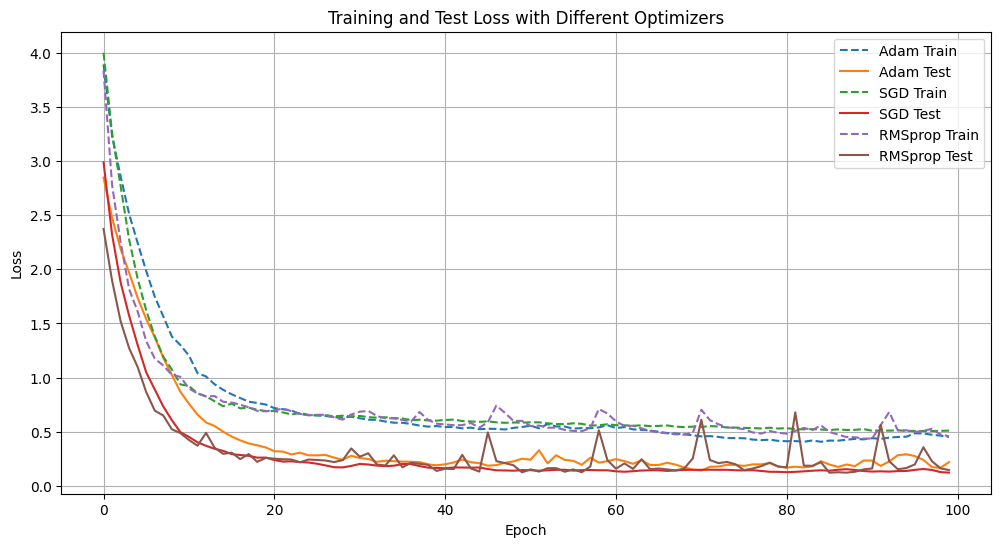

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.preprocessing import StandardScaler

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Data Preparation with Normalization
def prepare_data():
    faces = fetch_olivetti_faces()
    X, y = faces.data, faces.target

    # Normalize to [0, 1] range
    X = X / 255.0

    # Standardize features (mean=0, std=1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split by subject (40 people, 10 images each)
    X_train, y_train = [], []
    X_test, y_test = [], []
    for subject in range(40):
        idx = subject * 10
        X_train.extend(X[idx:idx+8])
        y_train.extend(y[idx:idx+8])
        X_test.extend(X[idx+8:idx+10])
        y_test.extend(y[idx+8:idx+10])

    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

# Enhanced Model with Regularization
class FaceNet(nn.Module):
    def __init__(self, input_dim, num_classes, l2_lambda=0.001, dropout_rate=0.5):
        super(FaceNet, self).__init__()

        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(128, num_classes)

        # L2 regularization parameter
        self.l2_lambda = l2_lambda

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.fc3(x)
        return x

    def l2_regularization(self):
        l2_reg = torch.tensor(0., requires_grad=True)
        for param in self.parameters():
            l2_reg = l2_reg + torch.norm(param, 2)**2
        return self.l2_lambda * l2_reg

# Training Function
def train_model(model, train_loader, test_loader, optimizer, epochs=100):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels) + model.l2_regularization()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Evaluate on test set
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                test_loss += criterion(outputs, labels).item()

        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")

    return train_losses, test_losses

# Main Experiment
def run_experiment():
    X_train, X_test, y_train, y_test = prepare_data()

    # Convert to tensors
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Model config
    input_dim = X_train.shape[1]
    num_classes = len(np.unique(y_train))

    # Define optimizers to compare (fixed the SGD definition)
    optimizers = {
        'Adam': lambda params: optim.Adam(params, lr=0.001),
        'SGD': lambda params: optim.SGD(params, lr=0.01, momentum=0.9),
        'RMSprop': lambda params: optim.RMSprop(params, lr=0.001)
    }

    # Store results
    results = {}

    for opt_name, opt_func in optimizers.items():
        print(f"\n=== Training with {opt_name} ===")

        model = FaceNet(input_dim, num_classes, l2_lambda=0.001, dropout_rate=0.3).to(device)
        optimizer = opt_func(model.parameters())  # Removed explicit lr parameter

        train_loss, test_loss = train_model(
            model, train_loader, test_loader, optimizer, epochs=100
        )

        results[opt_name] = {
            'train_loss': train_loss,
            'test_loss': test_loss
        }

    # Plot results
    plt.figure(figsize=(12, 6))
    for opt_name, res in results.items():
        plt.plot(res['train_loss'], '--', label=f'{opt_name} Train')
        plt.plot(res['test_loss'], label=f'{opt_name} Test')

    plt.title('Training and Test Loss with Different Optimizers')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Run the experiment
run_experiment()